In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
)

from sklearn.model_selection import GridSearchCV


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.7 MB/s eta 0:00:00a 0:00:01


Load and Inspect the Dataset

In [ ]:
# Load the dataset
data =  pd.read_csv('bank-additional-full.csv', sep=';') # Replace with actual file path


# Display dataset structure
print(data.info())  # Overview of features and data types
print(data.describe())  # Summary statistics for numerical columns
print(data.head())  # Display the first few rows to understand the structure



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Check for Missing Values

In [ ]:
# Check for any missing values in the dataset
print("Missing values in each column:\n", data.isnull().sum())

Missing values in each column:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


##**Target Variable Distribution and Correlation Analysis**

###Analyze Target Variable Distribution

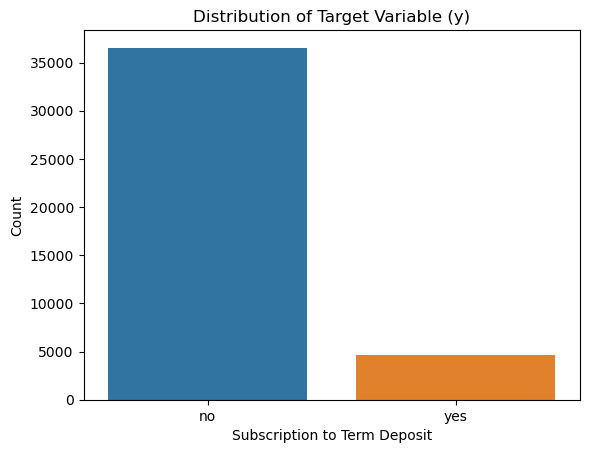

In [ ]:
# Analyze target distribution
sns.countplot(x='y', data=data)
plt.title('Distribution of Target Variable (y)')
plt.xlabel('Subscription to Term Deposit')
plt.ylabel('Count')
plt.show()


In [ ]:
# Check the distribution of the target variable
print(data['y'].value_counts())

y
no     36548
yes     4640
Name: count, dtype: int64


###Correlation Analysis

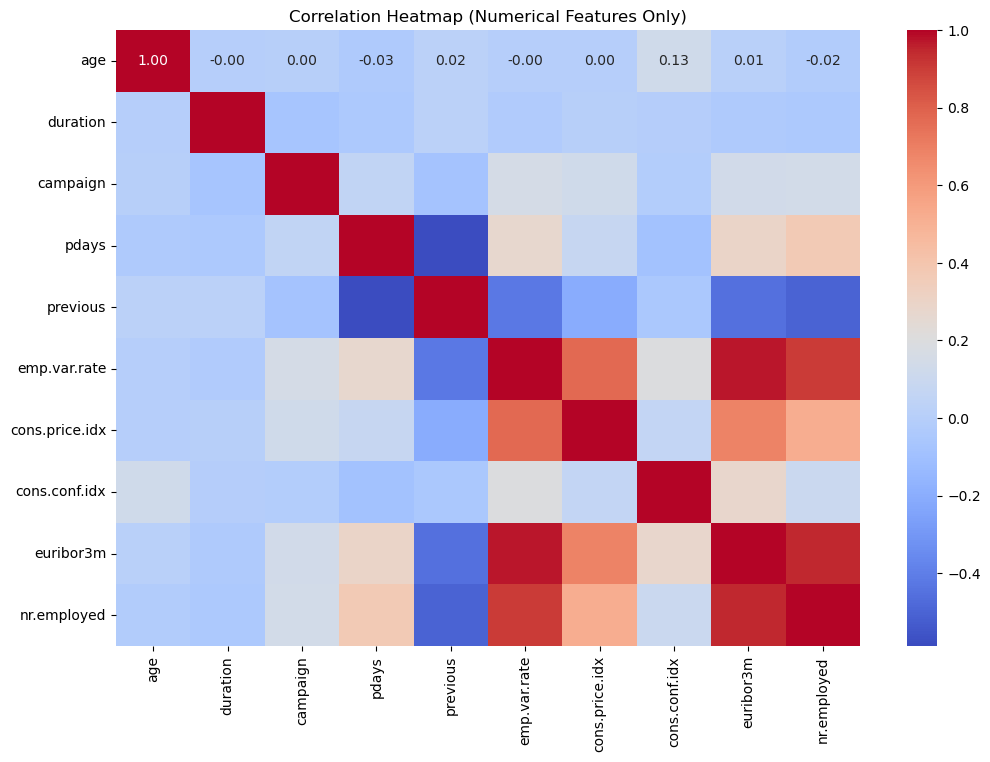

In [ ]:
# Correlation heatmap for numerical features only
numerical_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features Only)')
plt.show()


**Target Distribution:** Helps identify if the classes are imbalanced, which can affect model performance.<br>
**Correlation Heatmap:** Highlights relationships among numerical features, useful for detecting redundant features.

In [ ]:
# Set the threshold for high correlation
threshold = 0.5

# Create a mask to filter highly correlated features
# We will remove one of each pair of features that are highly correlated
correlation_matrix = numerical_data.corr().abs()  # Take absolute values for correlation

# Get the upper triangle of the correlation matrix (since it's symmetric)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features that are highly correlated (above the threshold)
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Print the highly correlated features
print(f"Highly correlated features (threshold > {threshold}): {highly_correlated_features}")


Highly correlated features (threshold > 0.5): ['previous', 'cons.price.idx', 'euribor3m', 'nr.employed']


##**Data Preprocessing**

###Encode Categorical Features



In [ ]:
# Encode categorical features
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':  # Exclude the target variable for separate encoding
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le


###Encode the Target Variable

In [ ]:
# Encode the target variable
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)


###Standardize Numerical Features

In [ ]:
# Separate features and target
X = data.drop('y', axis=1)
y = data['y']

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**LabelEncoder:** Converts categorical features into numeric values for compatibility with machine learning models.<br>
**StandardScaler:** Standardizes numerical features, which helps improve model performance for algorithms sensitive to feature scales.

##**Split the Dataset**

In [ ]:
# Split the dataset into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


**train_test_split:** Divides data into training and test sets, with 70% for training and 30% for evaluation.

Oversampling the Minority Class (SMOTE)
SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples of the minority class to balance the dataset.

In [ ]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the features and target
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new distribution of the target variable after oversampling
print(pd.Series(y_resampled).value_counts())

y
0    25580
1    25580
Name: count, dtype: int64


##**Define and Train Models**

###Initialize and Train Models

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')

}

# Dictionary to store evaluation results
results = {}

# Train each model and evaluate performance
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("="*50)


Model: Logistic Regression
Accuracy: 0.91, Precision: 0.66, Recall: 0.41, F1 Score: 0.50
Model: Naive Bayes
Accuracy: 0.85, Precision: 0.39, Recall: 0.61, F1 Score: 0.48
Model: K-Nearest Neighbors
Accuracy: 0.90, Precision: 0.59, Recall: 0.40, F1 Score: 0.48
Model: Decision Tree
Accuracy: 0.89, Precision: 0.52, Recall: 0.52, F1 Score: 0.52
Model: Random Forest
Accuracy: 0.91, Precision: 0.65, Recall: 0.51, F1 Score: 0.57
Model: XGBoost
Accuracy: 0.91, Precision: 0.64, Recall: 0.54, F1 Score: 0.58


This code trains each model and calculates evaluation metrics: Accuracy, Precision, Recall, and F1 Score.

##**Confusion Matrix, ROC Curve, and AUC**

##Confusion Matrix and Classification Report

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10968
           1       0.66      0.41      0.50      1389

    accuracy                           0.91     12357
   macro avg       0.80      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357



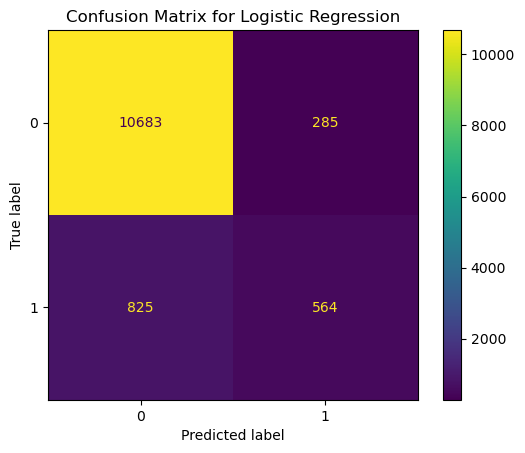

Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10968
           1       0.39      0.61      0.48      1389

    accuracy                           0.85     12357
   macro avg       0.67      0.75      0.70     12357
weighted avg       0.88      0.85      0.86     12357



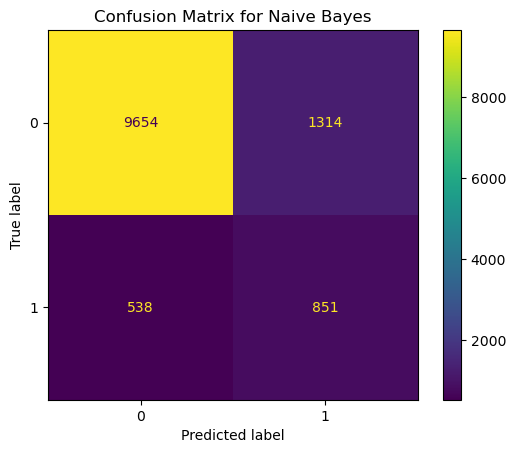

Classification Report for K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10968
           1       0.59      0.40      0.48      1389

    accuracy                           0.90     12357
   macro avg       0.76      0.68      0.71     12357
weighted avg       0.89      0.90      0.89     12357



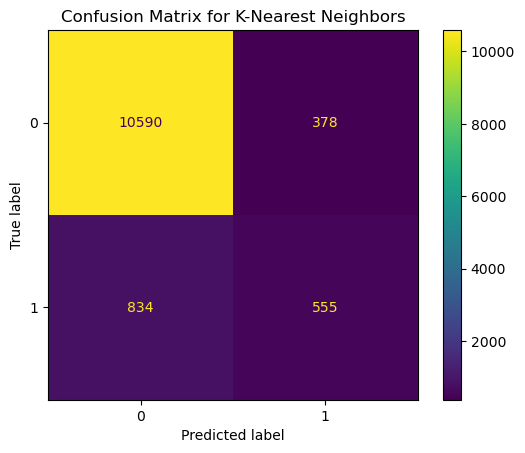

Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10968
           1       0.52      0.52      0.52      1389

    accuracy                           0.89     12357
   macro avg       0.73      0.73      0.73     12357
weighted avg       0.89      0.89      0.89     12357



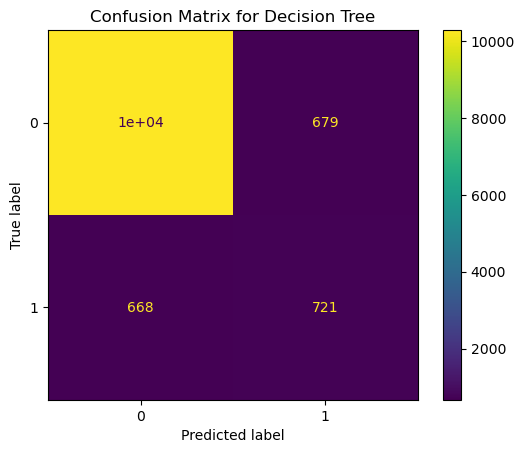

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10968
           1       0.65      0.51      0.57      1389

    accuracy                           0.91     12357
   macro avg       0.80      0.74      0.76     12357
weighted avg       0.91      0.91      0.91     12357



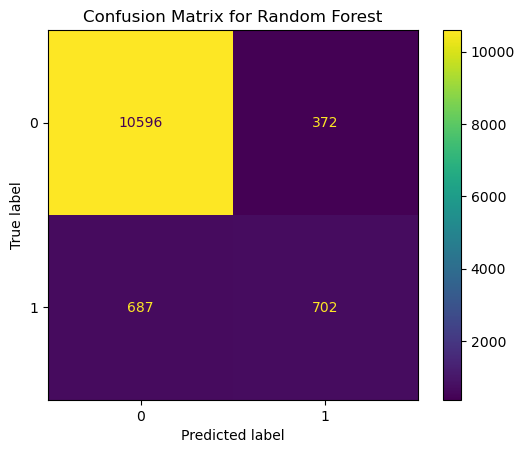

Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10968
           1       0.64      0.54      0.58      1389

    accuracy                           0.91     12357
   macro avg       0.79      0.75      0.77     12357
weighted avg       0.91      0.91      0.91     12357



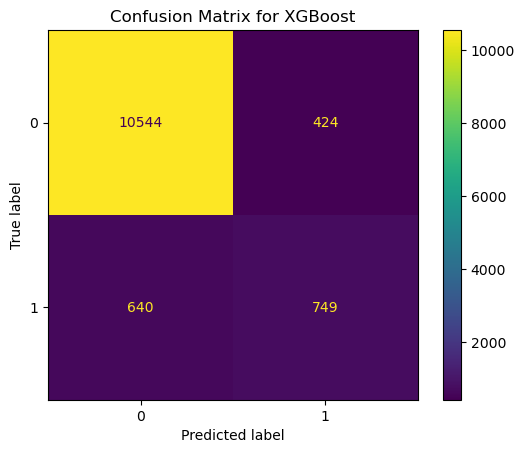

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrices and classification reports
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model_name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


**Classification Report:** Provides metrics such as precision, recall, and F1 for each class.<br>
**Confusion Matrix:** Helps visualize true positive, true negative, false positive, and false negative counts.

##**ROC Curve and AUC**

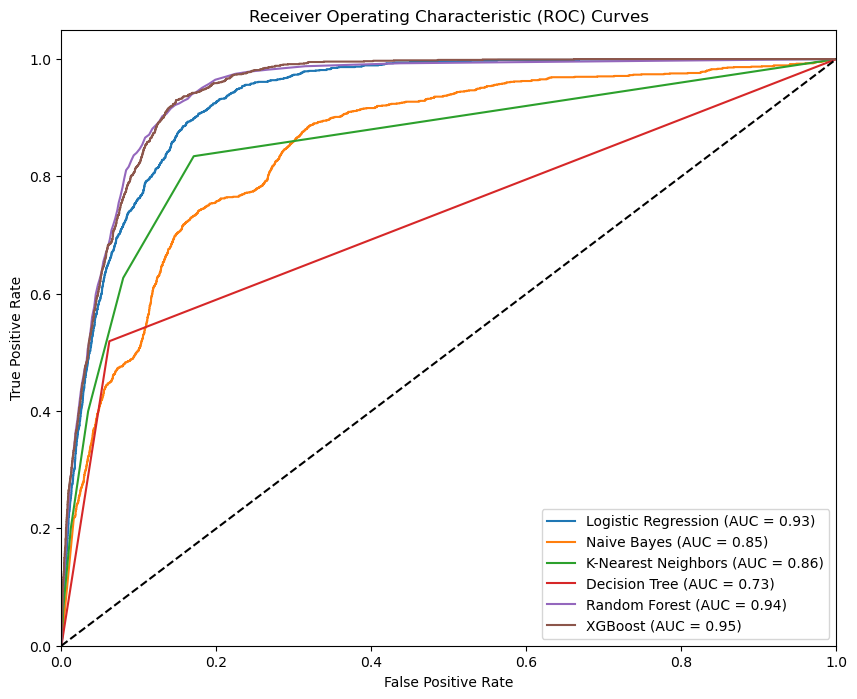

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


**ROC Curve:** Plots the trade-off between True Positive Rate and False Positive Rate.<br>
**AUC Score:** Summarizes the ROC curve performance; a higher AUC indicates better model performance.



### **1. Project Overview & Dataset**

This project applies machine learning models to predict customer subscription to a term deposit based on various features. The dataset includes 12,357 records with a significant class imbalance:

- **Class 0 (No Subscription)**: 10,968 (88.8%)
- **Class 1 (Subscription)**: 1,389 (11.2%)

**Key Challenge**: Handling the class imbalance, where the minority class (subscriptions) is much smaller.

---

### **2. Model Performance Analysis**

We tested six classification models: XGBoost, Random Forest, Logistic Regression, KNN, Naive Bayes, and Decision Tree. Here’s a brief summary of their performance:

#### **A. XGBoost (Best Performing Model)**
- **AUC**: 0.95 (Highest)
- **Accuracy**: 91%
- **Precision (Class 1)**: 64%
- **Recall (Class 1)**: 54%
- **F1 Score (Class 1)**: 58%
- **Strengths**: Best overall performance, robust against overfitting, and handles imbalanced classes well.

#### **B. Random Forest**
- **AUC**: 0.94
- **Accuracy**: 91%
- **Precision (Class 1)**: 64%
- **Recall (Class 1)**: 50%
- **F1 Score (Class 1)**: 56%
- **Strengths**: Close to XGBoost with good interpretability and feature importance insights.

#### **C. Logistic Regression**
- **AUC**: 0.93
- **Accuracy**: 91%
- **Precision (Class 1)**: 66% (Best)
- **Recall (Class 1)**: 41%
- **F1 Score (Class 1)**: 50%
- **Strengths**: Highest precision for Class 1, computationally efficient, and interpretable.

#### **D. KNN**
- **AUC**: 0.86
- **Accuracy**: 90%
- **Precision (Class 1)**: 59%
- **Recall (Class 1)**: 40%
- **F1 Score (Class 1)**: 48%
- **Strengths**: Simple and effective for local patterns, but struggles with class imbalance.

#### **E. Naive Bayes**
- **AUC**: 0.85
- **Accuracy**: 85%
- **Precision (Class 1)**: 39%
- **Recall (Class 1)**: 61%
- **F1 Score (Class 1)**: 48%
- **Strengths**: Fast and efficient, but low precision for Class 1.

#### **F. Decision Tree**
- **AUC**: 0.73 (Lowest)
- **Accuracy**: 89%
- **Precision (Class 1)**: 52%
- **Recall (Class 1)**: 51%
- **F1 Score (Class 1)**: 51%
- **Strengths**: Easy to interpret but prone to overfitting and lower AUC.

---

### **3. Performance Comparison Table**

| Metric                | XGBoost | Random Forest | Logistic Regression | KNN  | Naive Bayes | Decision Tree |
|-----------------------|---------|---------------|---------------------|------|-------------|---------------|
| **AUC**               | 0.95    | 0.94          | 0.93                | 0.86 | 0.85        | 0.73          |
| **Accuracy**          | 0.91    | 0.91          | 0.91                | 0.90 | 0.85        | 0.89          |
| **Precision (Class 1)**| 0.64   | 0.64          | 0.66                | 0.59 | 0.39        | 0.52          |
| **Recall (Class 1)**  | 0.54    | 0.50          | 0.41                | 0.40 | 0.61        | 0.51          |
| **F1 Score (Class 1)**| 0.58    | 0.56          | 0.50                | 0.48 | 0.48        | 0.51          |

---

### **4. Key Findings & Recommendations**

#### **Best Model**: **XGBoost**
- **Why**: XGBoost has the highest AUC, making it the most accurate model for distinguishing between the two classes, especially with imbalanced data.

#### **Alternative Model**: **Random Forest**
- Very close performance to XGBoost, with better interpretability and feature importance insights.

#### **Baseline Model**: **Logistic Regression**
- Simple and efficient, with the highest precision for predicting Class 1 (subscription).

#### **Improvement Strategies**:
- **Class Imbalance Handling**: Use techniques like **SMOTE** or **weighted classes** to improve performance on the minority class.
- **Hyperparameter Tuning**: Explore tuning options for Random Forest and XGBoost to optimize performance.
  


##**Hyperparameter Tuning**

###Hyperparameter Tuning for K-Nearest Neighbors

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define an expanded parameter grid
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto']
}

grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_weighted'  # Alternative scoring metric
)


# Fit the model to the scaled training data
grid_search_knn.fit(X_train_scaled, y_train)

# Output the best hyperparameters and the best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best F1 score for KNN:", grid_search_knn.best_score_)

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Best F1 score for KNN: 0.8929857417015856


###Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define expanded parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],             # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],         # Depth of each tree
    'min_samples_split': [2, 5, 10],                 # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                   # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None]           # Number of features to consider for splits
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search_rf.fit(X_train, y_train)

# Output the best hyperparameters and the best F1 score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best F1 score for Random Forest:", grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best F1 score for Random Forest: 0.5956029261072937


**GridSearchCV:** Tests combinations of hyperparameters using cross-validation to find the optimal set for each model.<br>
**Tuning Parameters:** Adjusting n_neighbors for KNN and n_estimators, max_depth for Random Forest based on F1 score.